In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
def remove_stopwords(sentence):
    # List of stopwords
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
    
    # Sentence converted to lowercase-only
    sentence = str(sentence).lower()
    
    ### START CODE HERE
    words = sentence.split()
    result = [word for word in words if word not in stopwords]
    sentence = " ".join(result)
    
   
    ### END CODE HERE
    return sentence

In [4]:
import requests
import json

dataset_url = "https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json"
response = requests.get(dataset_url)

if (response.status_code == 200):
    data = response.json()

    # print(json.dumps(data, indent=4))
else:
    print(f"Failed to retrieve the JSON file. Status code: {response.status_code}")

sentences = []
labels = []
url = []
for item in data:
    sentences.append(remove_stopwords(item["headline"]))
    labels.append(item["is_sarcastic"])

In [5]:
vocab_size = 10000
embedding_dim = 16
max_length = 32
trunc_type = "post"
padding_type = "post"
oov_tok = "<OOV>"
training_size = 20000

In [6]:
import numpy as np

labels = np.array(labels)

In [7]:
training_sentences = sentences[:training_size]
training_labels = labels[:training_size]

test_sentences = sentences[training_size:]
test_labels = labels[training_size:]

In [8]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, padding=padding_type, 
                       maxlen=max_length,truncating=trunc_type)


test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, padding=padding_type, 
                       maxlen=max_length,truncating=trunc_type)

In [14]:
model = keras.models.Sequential(
    [
        layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(32)),
        # layers.GlobalAveragePooling1D(),
        layers.Dense(24, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ]
)

model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [15]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
print(f"padded shape: {padded.shape}")
print(f"training_labels shape: {training_labels.shape}")
print(f"test_padded shape: {test_padded.shape}")
print(f"test_labels shape: {test_labels.shape}")

padded shape: (20000, 32)
training_labels shape: (20000,)
test_padded shape: (6709, 32)
test_labels shape: (6709,)


In [17]:
num_epochs = 30

history = model.fit(
    padded,
    training_labels,
    validation_data=(test_padded, test_labels),
    epochs=num_epochs
)

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - accuracy: 0.6755 - loss: 0.5757 - val_accuracy: 0.7968 - val_loss: 0.4384
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.8803 - loss: 0.2879 - val_accuracy: 0.7964 - val_loss: 0.4507
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.9157 - loss: 0.2100 - val_accuracy: 0.7909 - val_loss: 0.4710
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.9443 - loss: 0.1460 - val_accuracy: 0.7860 - val_loss: 0.5348
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.9646 - loss: 0.0991 - val_accuracy: 0.7849 - val_loss: 0.6184
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.9772 - loss: 0.0661 - val_accuracy: 0.7830 - val_loss: 0.8120
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.9838 - loss: 0.0473 - val_accuracy: 0.7818 - val_loss: 0.9432
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.9874 - loss: 0.0363 - 

Text(0.5, 1.0, 'Training and validation loss')

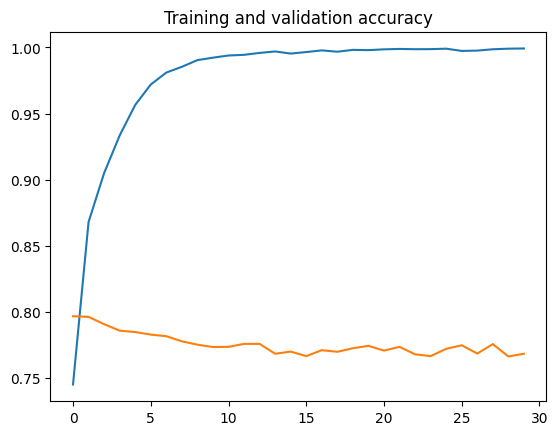

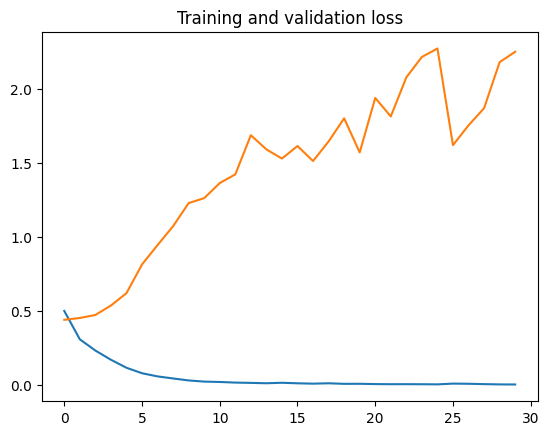

In [18]:
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history['accuracy' ]
val_acc  = history.history['val_accuracy' ]
loss     = history.history['loss']
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs,acc )
plt.plot  (epochs,val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

In [51]:
# Get the embedding layer from the model (i.e. first layer)
embedding_layer = model.layers[0]

# Get the weights of the embedding layer
embedding_weights = embedding_layer.get_weights()[0]

# Print the shape. Expected is (vocab_size, embedding_dim)
print(embedding_weights.shape) 

(10000, 16)


In [52]:
# Get the index-word dictionary
reverse_word_index = tokenizer.index_word

In [53]:
import io

# Open writeable files
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

# Initialize the loop. Start counting at `1` because `0` is just for the padding
for word_num in range(1, vocab_size):

  # Get the word associated at the current index
  word_name = reverse_word_index[word_num]

  # Get the embedding weights associated with the current index
  word_embedding = embedding_weights[word_num]

  # Write the word name
  out_m.write(word_name + "\n")

  # Write the word embedding
  out_v.write('\t'.join([str(x) for x in word_embedding]) + "\n")

# Close the files
out_v.close()
out_m.close()

Next, you will build the model. The architecture is similar to the previous lab but you will use a `GlobalAveragePooling1D` layer instead of `Flatten` after the Embedding. This adds the task of averaging over the sequence dimension before connecting to the dense layers. See a short demo of how this works using the snippet below. Notice that it gets the average over 3 arrays `(i.e. (10 + 1 + 1) / 3` and `(2 + 3 + 1) / 3` to arrive at the final output.

In [54]:
import tensorflow as tf

# Initialize a GlobalAveragePooling1D (GAP1D) layer
gap1d_layer = tf.keras.layers.GlobalAveragePooling1D()

# Define sample array
sample_array = np.array([[[10,2],[1,3],[1,1]]])

# Print shape and contents of sample array
print(f'shape of sample_array = {sample_array.shape}')
print(f'sample array: {sample_array}')

# Pass the sample array to the GAP1D layer
output = gap1d_layer(sample_array)

# Print shape and contents of the GAP1D output array
print(f'output shape of gap1d_layer: {output.shape}')
print(f'output array of gap1d_layer: {output.numpy()}')

shape of sample_array = (1, 3, 2)
sample array: [[[10  2]
  [ 1  3]
  [ 1  1]]]
output shape of gap1d_layer: (1, 2)
output array of gap1d_layer: [[4. 2.]]
